In [1]:
from astropy import constants as const
from astropy import units as u
from random import *
from parameter_generator import *
from scipy.stats import stats
from scipy.stats import norm
import scipy.integrate as integrate
from iminuit import Minuit
import pysynphot as S
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0   

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [2]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from regions import CircleSkyRegion

result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg')
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

# Cadence

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)

In [4]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv', index_col = 0)

In [5]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [6]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

%time

Wall time: 0 ns


In [7]:
rg = RealisticGenerator(xvts=1000000)
param=rg.generate_parameters(mass = 100, nb_parameters=1000)

369463 0.369463


Text(0.5, 0, '$u_0$')

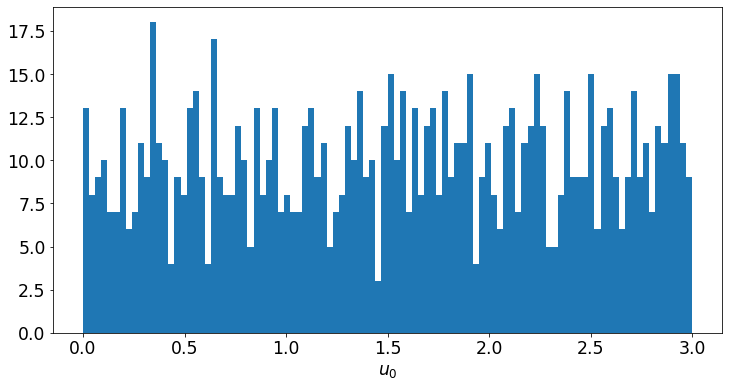

In [8]:
plt.hist(param["u0"],bins=100);
plt.xlabel("$u_0$")

Text(0.5, 0, '$t_0$')

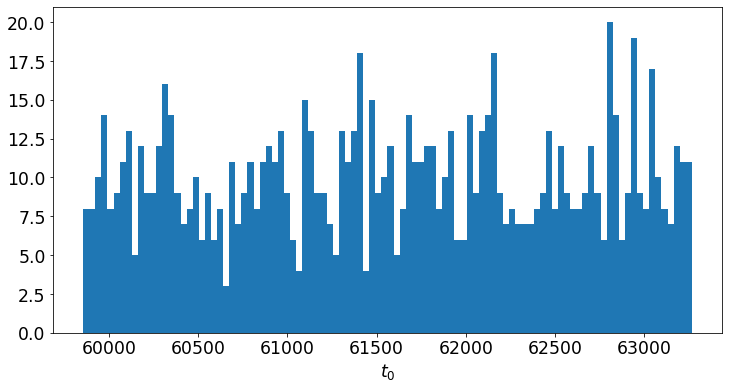

In [9]:
plt.hist(param["t0"],bins=100);
plt.xlabel("$t_0$")

Text(0.5, 0, '$t_E$ distribution for M = 10 Solar Masses')

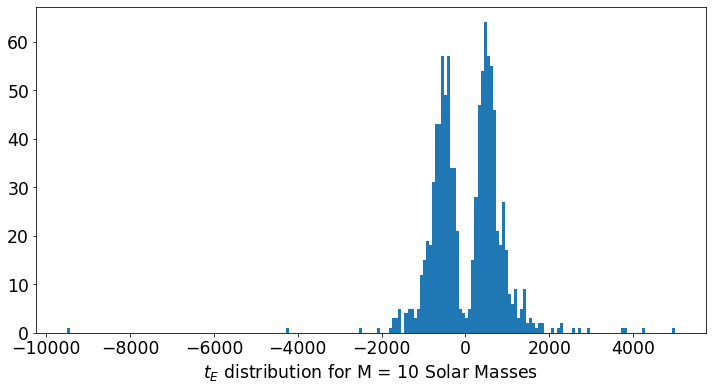

In [10]:
plt.hist(param["tE"],bins=200);
plt.xlabel("$t_E$ distribution for M = 10 Solar Masses")
#plt.xlim(0,1000)

In [11]:
#Distribution t_0

NYEARS = 10
NDAYS = NYEARS*365.25
from scipy.stats import uniform
xmin = 0
xmax = NDAYS
N = 1000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N)+ df["observationStartMJD"][0]

#plt.hist(list_t0,bins=int(NDAYS));
#plt.xlabel("$t_0$ (jours)")
#plt.title("Distribution des $t_0$")

In [12]:
#Distribution u0

N = 1000
uminmin = 0
uminmax = 3
umin = uniform.rvs(uminmin,uminmax,N)

#plt.hist(umin,bins=100)
#plt.xlabel("$u_{min}$")
#plt.ylabel("$p(u_{min})$")
#plt.title("Densité de probabilité de $u_{min}$")

In [13]:
#relative angular source-lens separation

def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [14]:
#Amplitude

def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [15]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

In [16]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4)

In [17]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

In [18]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [19]:
D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)
Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)


In [20]:
F_b = []
N_pe = []
bp_atmo = []
all_obs = []
all_count = []
sigma_N = []
amp_err = []
all_bp = []

for i in range (len(df['observationStartMJD'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)


for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);
    
for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((y * Observation 85)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 86)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 87)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 88)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 89)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 90)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 91)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 92)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Observation 172)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 173)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 174)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 175)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 176)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 177)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 178)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 179)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 257)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 258)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 259)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 260)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 261)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 262)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 263)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 264)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 342)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 343)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 344)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 345)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 346)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 347)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 348)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 349)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 429)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 430)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 431)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 432)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 433)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 434)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 435)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 436)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 517)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 518)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 519)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 520)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 521)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 522)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 523)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 524)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 599)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 600)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 601)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 602)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 603)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 604)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 605)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 606)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 681)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 682)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 683)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 684)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 685)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 686)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 687)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 688)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 769)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 770)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 771)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 772)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 773)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 774)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 775)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 776)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 856)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 857)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 858)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 859)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 860)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 861)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 862)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 863)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [21]:
for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

In [22]:
for i in range (len(F_b)) :
    
    if (df['filter'].values[i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'].values[i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))


In [23]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [24]:
%%time

chi2 = []
chi2_linear = []
#tE = 20
Delta_chi2 = []
Ndof = []
rejected_events = 0

for i in range (len(param["t0"])) :
    
    t0 = param["t0"][i]      
    u0 = param["u0"][randrange(len(param["u0"]))]   #random u0 for every event 
    tE = param["tE"][randrange(len(param["tE"]))] 
    tmin = t0 - 5.*abs(tE)
    tmax = t0 + 5.*abs(tE)
    
    #df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
    
    
    #df_event_times = df_event["observationStartMJD"].values

    #x = df_event_times                                   # We consider every data point (no distinction between filters)
    
    #y_data = A(u(df_event_times))
    
    #Photometric Error
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    

#Restrictive cuts 
    
    if (#len(x) > 1                                                # Ndof microlensing > 1                                           
        len(x) - m.nfit > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0                                           # Chi2 linear != 0
        and m.fval/(len(x) - m.nfit) < 2                                # Goodness of fit chi2/Ndof < 2
        and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 80 ) :  
        
        Ndof.append(len(x) - m.nfit)
        
        chi2.append(m.fval)
         
        chi2_linear.append(m_linear.fval)
        
        Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((2*(len(x)- m.nfit)))))
        
    else :
        
        rejected_events += 1

        
print(rejected_events)

418
Wall time: 45.6 s


Text(0, 0.5, 'chi2')

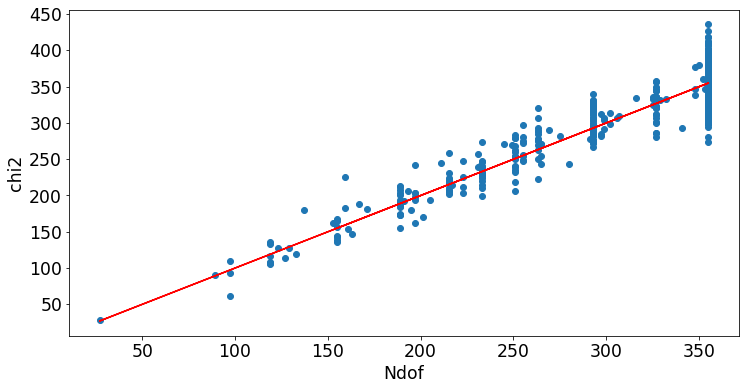

In [25]:
plt.plot(Ndof,Ndof, color = 'r')
plt.scatter(Ndof, chi2)
plt.xlabel("Ndof")
plt.ylabel("chi2")
#plt.xlim([0,20])
#plt.ylim([0,1])

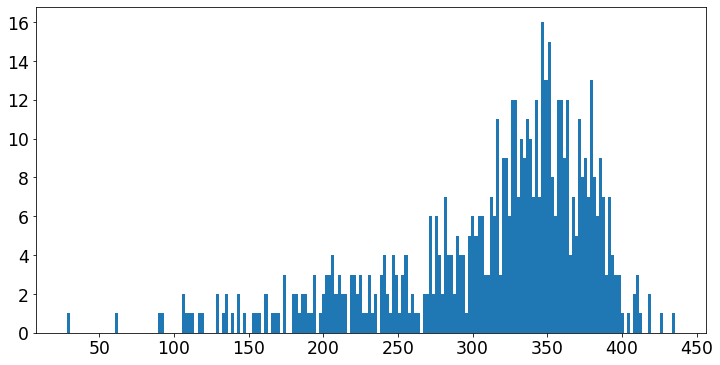

In [26]:
plt.hist(chi2, bins= 200);

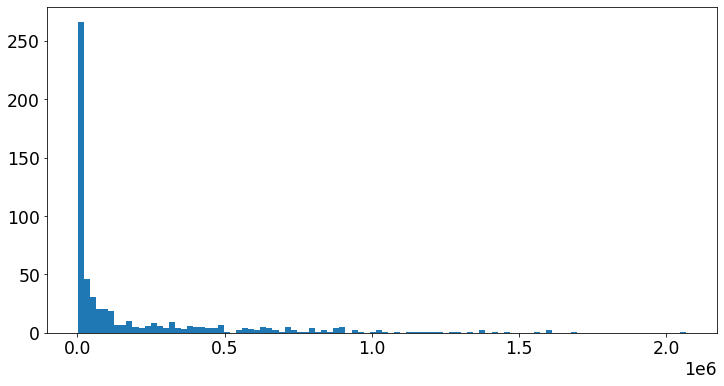

In [27]:
plt.hist(chi2_linear, bins = 100);

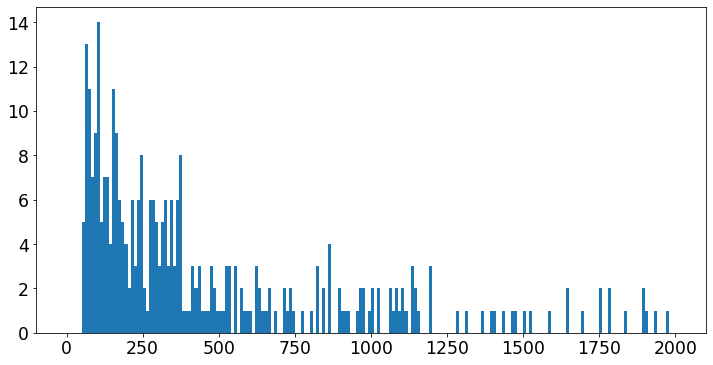

In [28]:
plt.hist(Delta_chi2, bins = 200, range = [0,2000]);
#plt.ylim(0,100)

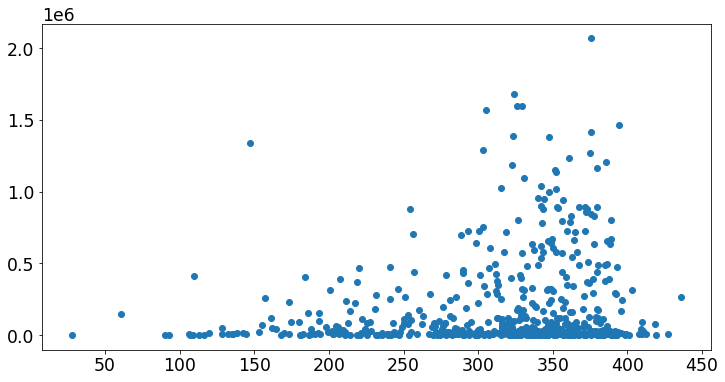

In [29]:
plt.scatter(chi2, chi2_linear)
#plt.ylim([0,200])